<a href="https://colab.research.google.com/github/Harshita-Dubey/uterine-cancer-detection/blob/main/UterineCancerDeetectionW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

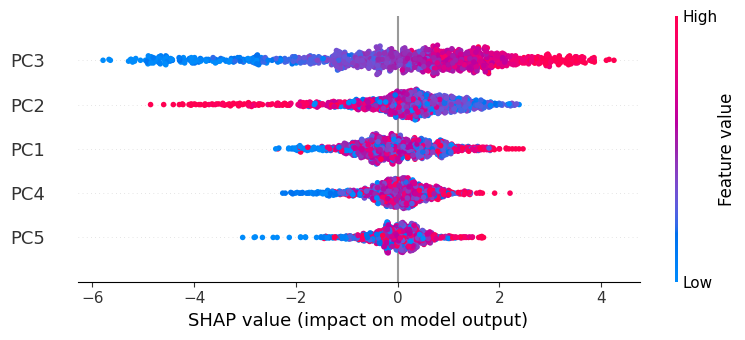

In [2]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


# Generate synthetic data
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, n_clusters_per_class=2, weights=[0.7, 0.3],
                           random_state=42)

# Convert to DataFrame
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(20)])
df["Cancer Type Detailed"] = y

# Feature correlation analysis (removing highly correlated features)
correlation = df.corr()["Cancer Type Detailed"].abs().sort_values(ascending=False)
high_corr_features = correlation[correlation > 0.9].index.tolist()
if "Cancer Type Detailed" in high_corr_features:
    high_corr_features.remove("Cancer Type Detailed")
df.drop(columns=high_corr_features, inplace=True)

# Define features and target
X = df.drop(columns=["Cancer Type Detailed"])
y = df["Cancer Type Detailed"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# K-Means Clustering for Patient Subgrouping
kmeans = KMeans(n_clusters=3, random_state=42)
patient_clusters = kmeans.fit_predict(X)
X["Cluster"] = patient_clusters  # Add clusters as a feature

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Selection using Recursive Feature Elimination (RFE)
rf_selector = RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=10)
X_train_selected = rf_selector.fit_transform(X_train, y_train)
X_test_selected = rf_selector.transform(X_test)

# Dimensionality Reduction using PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Hyperparameter Tuning for LightGBM
param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [8, 10, 12],
    "learning_rate": [0.05, 0.07, 0.1],
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_pca, y_train)

# Train the best LightGBM model
best_lgbm = grid_search.best_estimator_
best_lgbm.fit(X_train_pca, y_train)

# Train SVM & Random Forest
svm_model = SVC(kernel="linear", probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model.fit(X_train_pca, y_train)
rf_model.fit(X_train_pca, y_train)

# Stacking Ensemble (XGBoost + LightGBM + RF + SVM)
ensemble_model = StackingClassifier(
    estimators=[
        ("rf", rf_model),
        ("xgb", best_lgbm),
        ("svm", svm_model),
    ],
    final_estimator=LGBMClassifier(n_estimators=50, random_state=42)
)
ensemble_model.fit(X_train_pca, y_train)

# Save the optimized model & scaler
joblib.dump(ensemble_model, "optimized_uterine_cancer_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Best model and scaler saved successfully!")

# Evaluate Model
y_pred_proba = ensemble_model.predict_proba(X_test_pca)[:, 1]
y_pred = (y_pred_proba >= 0.35).astype(int)  # Lower threshold to reduce false negatives

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Reinforcement Learning (Q-Learning for Treatment Optimization)
import gym

class CancerTreatmentEnv(gym.Env):
    def __init__(self):
        self.state = np.random.randint(0, 5)  # Discrete state space
        self.action_space = gym.spaces.Discrete(3)  # 3 treatment options
        self.observation_space = gym.spaces.Discrete(5)  # 5 patient states

    def step(self, action):
        reward = np.random.rand()  # Simulate treatment effectiveness
        self.state = np.random.randint(0, 5)  # Update patient condition
        done = np.random.rand() > 0.9  # Simulate treatment success/failure
        return self.state, reward, done, {}

env = CancerTreatmentEnv()

# Implement Q-learning Algorithm
Q_table = np.zeros((5, 3))  # 5 patient states, 3 treatments
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor

for episode in range(1000):  # Train for 1000 episodes
    state = np.random.randint(0, 5)  # Discrete initial state
    done = False
    while not done:
        action = np.argmax(Q_table[state])  # Select best action
        new_state, reward, done, _ = env.step(action)
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[new_state]))
        state = new_state  # Update state

print("\nReinforcement Learning (Q-Learning) Training Complete!")

# SHAP Explainability
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_train_pca)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
plt.show()


In [ ]:
!pip install lightgbm
